# Analysis of HPT pregnancy dynamics

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
import json
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import rfft,fft,fftfreq,rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit,brute,basinhopping
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import math
from itertools import combinations
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from string import ascii_uppercase as abc; abc = abc
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from itertools import compress, product
import random
from scipy.interpolate import InterpolatedUnivariateSpline as spline_interp
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patheffects as PathEffects
matplotlib_axes_logger.setLevel('ERROR')
np.seterr(divide='ignore', invalid='ignore')

def_color  = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

init_printing()
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=8) 
matplotlib.rcParams["figure.dpi"] = 100

# General functions

In [2]:
def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def remove_axe_labels(ax):
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
def to_dict(keys,values):
    return dict(zip(keys,values))

def get_test_dataframe(path,file):
    tdf       = pd.read_csv(path+file)
    tdf.index = np.array([np.array(s.replace('[','').replace(')','').split(',')).astype(int).mean() for s in tdf['week']])
    tdf       = tdf.drop(columns=['week'])
    tdf.rename(columns={"age50": "age"},inplace=True)
    
    if len(tdf)<140:
        missing_index = np.sort(list(set(np.arange(-59.5,80.5,1)) - set(tdf.index)))
        tdf = tdf.T
        [tdf.insert(int(np.argwhere(np.arange(-59.5,80.5,1) == missing_index[i])[0][0]),missing_index[i],np.nan) for i in range(len(missing_index))]
        tdf = tdf.T
    return tdf

# Loading the dataset
### Metadata infotmation
* 'metadata' - Tests names in various forms, divison to groups and units
* 'labnorm'  - Referenence values for tests

We consider only tests with reference values and remove tests with missing bins (86 tests)

In [3]:
# Loading the dataset into 'dfs'
path          = '../Clalit Data/pregnancy.1w/'
files         = [file for file in os.listdir(path)]
all_tests     = [file.split('.')[0] for file in files]
dfs           = dict(zip(all_tests,[get_test_dataframe(path,file) for file in files]))

# We removed duplicate tests
# Duplicate tests include K:POTASSIUM_BLOOD, Na:SODIUM_BLOOD, RDW:RDW_CV
remove        = ['POTASSIUM_BLOOD','SODIUM_BLOOD','RDW_CV']
all_tests     = np.unique(list(set(all_tests)- set(remove)))

groups        = ['Liver','Renal','Musculoskeletal','Metabolism','RBCs','Coagulation','Immune','Endocrine']
metadata      = pd.read_excel('../Files/Metadata.xlsx',index_col=0).drop(remove)
labnorm       = pd.read_csv('../Files/LabNorm.csv')

ndf           = pd.DataFrame([dfs[test]['n'] for test in all_tests],index=all_tests).fillna(0).astype(int)
labnorm_tests = list(metadata.loc[~metadata['LabNorm name'].isna()].index)
bias_df       = pd.read_csv('../Files/bias_score_070523.csv',index_col=0)
bias_tests    = set(bias_df.loc[bias_df.sum(axis=1)<3].index)
removed_tests = set(list(set(all_tests) - set(labnorm_tests)) + list(bias_tests))
tests         = sorted(list(set(labnorm_tests).intersection(all_tests) - set(removed_tests)))
len(tests)

In [4]:
def get_age_matched_reference(test):
    age  = int(np.nanmedian(dfs[test]['age']))
    tdf  = labnorm.loc[(labnorm.age==age)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].fillna(method='ffill').fillna(method='bfill').copy()
    tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
    prob = np.diff(tdf['quantile'])/np.sum(np.diff(tdf['quantile']))
    mu_  = (tdf.value.iloc[1:]*prob).sum()
    sd_  = np.sqrt((prob*((tdf.value.iloc[1:] - mu_)**2)).sum())
    q_to_val = interp1d(tdf['quantile'],tdf['value'])
    return {'quantile':q_to_val,'mean':mu_,'sd':sd_}

def get_value_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['mean']
    e   = tdf['sd']/np.sqrt(tdf['n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_quantile_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['qmean']
    e   = (tdf['qq75'] - tdf['qq25'])/(np.sqrt(tdf['n'])*0.675*2)
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_value_at_quantile_stats(test):
    tdf = get_quantile_stats(test)
    if test in labnorm_tests:
        ref = get_age_matched_reference(test)
        v   = ref['quantile'](tdf['value'])
        e_p = ref['quantile'](tdf['value']+tdf['error'])
        e_m = ref['quantile'](tdf['value']-tdf['error'])
        e   = ((e_p - v) + (v-e_m))/2
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_SDS_stats(test):
    tdf      = get_value_stats(test)
    if test in labnorm_tests:
        ref      = get_age_matched_reference(test)
        ref_mean = ref['mean'] 
        ref_sd   = ref['sd']
        v        = (tdf['value'] - ref_mean) / ref_sd
        e        = tdf['error'] / ref_sd
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_stats_from_dataset(test,stat,period=[-60,80],merge_timepoints = True):
    
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    split_k = 1
    if merge_timepoints:
        split_k  = np.min([int(np.ceil(np.nanmean((df['error']/(df['value'].std() * 0.15))**2))),7])
        
        if split_k > 1:
            df     = df.reset_index()
            splits = np.array_split(df, int(len(df)/split_k))
            x      = np.array([tdf['index'].mean()                                   for tdf in splits])
            n      = np.array([tdf['n'].sum()                                        for tdf in splits])
            v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
            sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
            e      = sd/np.sqrt(n)
            df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)
   
    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n      

In [5]:
def get_postpartum_relative_change_stats(test):
    df       = get_value_at_quantile_stats(test)
    df['sd'] = df['error']*np.sqrt(df['n'])    
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    sd_end   = np.sqrt(np.sum(df.loc[70:]['n']*df.loc[70:]['sd']**2)/(np.sum(df.loc[70:]['n'])))    
    v        = df['value']/mu_end - 1
    e        = df['error']/mu_end
    return pd.DataFrame(np.array([df['n'],v,e]).T,index=df.index,columns=['n','value','error'])

def get_relative_change_norm_baselines_stats(test):
    df       = get_value_at_quantile_stats(test)
    df['sd'] = df['error']*np.sqrt(df['n'])    
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    mu_start = np.sum(df.loc[:-50]['n']*df.loc[:-50]['value'])/(np.sum(df.loc[:-50]['n']))
    v        = pd.concat([df['value'].loc[:0]/mu_start, df['value'].loc[0:]/mu_end]) - 1
    e        = pd.concat([df['error'].loc[:0]/mu_start, df['error'].loc[0:]/mu_end])
    return pd.DataFrame(np.array([df['n'],v,e]).T,index=df.index,columns=['n','value','error'])

def get_test_data(test):
    return {'mean'             :get_value_stats(test),
            'quantile'         :get_quantile_stats(test),
            'value_at_quantile':get_value_at_quantile_stats(test),
            'SDS'              :get_SDS_stats(test),
            'postpartum_change':get_postpartum_relative_change_stats(test),
            'norm_baselines'   :get_relative_change_norm_baselines_stats(test)}

def get_stats_from_dataset_by_split(test,stat,period=[-60,80],split_k = 2):
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    if split_k > 1:
        df     = df.reset_index()
        splits = np.array_split(df, int(len(df)/split_k))
        x      = np.array([tdf['index'].mean()                                   for tdf in splits])
        n      = np.array([tdf['n'].sum()                                        for tdf in splits])
        v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
        sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
        e      = sd/np.sqrt(n)
        df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)

    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n      

data = {test:get_test_data(test) for test in tqdm(tests)}

  0%|          | 0/78 [00:00<?, ?it/s]

## Thyroid tests - T4 free and TSH show complex dynamics postpartum

In [6]:
def plot_thyroid(test,stat,ax,split_k=2,period=[5,80]):
    
    x,v,e,n = get_stats_from_dataset_by_split(test,stat,period=period,split_k=split_k)
    if stat == 'norm_baselines':
        v = v*100
        e = e*100
        
    ax.errorbar(x,v,e,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
    ax.set_xlabel('Weeks postpartum',fontsize=8)
    
    if stat=='postpartum_change':
        ax.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax.get_yticks()])
        ax.set_ylabel(metadata.loc[test]['Nice name'] + '\nrelative change (%)',fontsize=8)
    if stat=='value_at_quantile' :   
        ax.set_ylabel(metadata.loc[test]['Nice name']+'\nValue at mean quantile',fontsize=8)
         

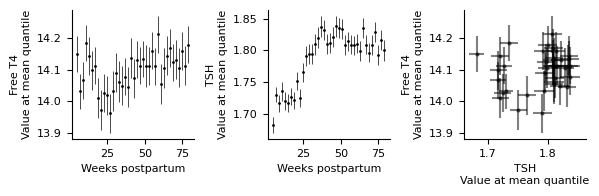

In [7]:
plt.figure(figsize=(6,2))
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)

x,ydat_y3,yerr_y3,n_y3 = get_stats_from_dataset_by_split('T4_FREE','value_at_quantile',period=[5,80],split_k=2)
plot_thyroid('T4_FREE','value_at_quantile',ax1)

x,ydat_y2,yerr_y2,n_y2 = get_stats_from_dataset_by_split('TSH_THYROID_STIMULATING_HORMONE','value_at_quantile',period=[5,80],split_k=2)
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','value_at_quantile',ax2)

ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2,alpha=0.5)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nValue at mean quantile')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nValue at mean quantile')

remove_top_right_frame([ax1,ax2,ax3])
plt.tight_layout();
plt.savefig('thyroid_curves_postpartum.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

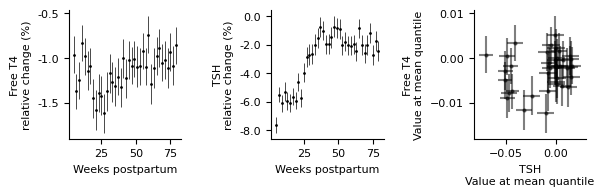

In [8]:
plt.figure(figsize=(6,2))
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)

x,ydat_y3,yerr_y3,n_y3 = get_stats_from_dataset_by_split('T4_FREE','postpartum_change',period=[5,80],split_k=2)
plot_thyroid('T4_FREE','postpartum_change',ax1)

x,ydat_y2,yerr_y2,n_y2 = get_stats_from_dataset_by_split('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',period=[5,80],split_k=2)
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)

ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2,alpha=0.5)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nValue at mean quantile')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nValue at mean quantile')

remove_top_right_frame([ax1,ax2,ax3])
plt.tight_layout(); 
plt.savefig('thyroid_curves_postpartum_fold_change.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

### Yael's HPT model 
from "Dynamics of thyroid diseases and thyroid-axis gland masses" MSB (2022)

$x_1,x_2,x_3$ are $TRH, TSH$ and $FT4$ blood concentration

$P,T$ are the functional masses of the pituitary and thyroid hormone secreting cells

In [9]:
x1,x2,x3,m1,m2,a1,a2,a3,b1,b2,b3,bp,bt,ap,at = symbols('x_1,x_2,x_3,m_1,m_2,a_1,a_2,a_3,b_1,b_2,b_3,b_P,b_T,a_P,a_T',positive=True)
t,p      = symbols('t,p' ,positive=True)
X1       = Function('x_1',positive=True)(t)
X2       = Function('x_2',positive=True)(t)
X3       = Function('x_3',positive=True)(t)
P        = Function('P',positive=True)(t)
T        = Function('T',positive=True)(t)

dx1      = b1/X3       - a1*X1  
dx2      = b2*P*X1/X3 - a2*X2       
dx3      = b3*T*X2    - a3*X3    
dP       = P*(bp/X3   - ap)
dT       = T*(bt*X2   - at)

deqs     = Matrix([Eq(X1.diff(t), dx1),
                   Eq(X2.diff(t), dx2),
                   Eq(X3.diff(t), dx3),
                   Eq(P.diff(t), dP),
                   Eq(T.diff(t), dT)])

display(deqs)

⎡    d                         b₁     ⎤
⎢    ──(x₁(t)) = -a₁⋅x₁(t) + ─────    ⎥
⎢    dt                      x₃(t)    ⎥
⎢                                     ⎥
⎢d                       b₂⋅P(t)⋅x₁(t)⎥
⎢──(x₂(t)) = -a₂⋅x₂(t) + ─────────────⎥
⎢dt                          x₃(t)    ⎥
⎢                                     ⎥
⎢d                                    ⎥
⎢──(x₃(t)) = -a₃⋅x₃(t) + b₃⋅T(t)⋅x₂(t)⎥
⎢dt                                   ⎥
⎢                                     ⎥
⎢   d          ⎛        b_P ⎞         ⎥
⎢   ──(P(t)) = ⎜-a_P + ─────⎟⋅P(t)    ⎥
⎢   dt         ⎝       x₃(t)⎠         ⎥
⎢                                     ⎥
⎢ d                                   ⎥
⎢ ──(T(t)) = (-a_T + b_T⋅x₂(t))⋅T(t)  ⎥
⎣ dt                                  ⎦

The steady state of the model:

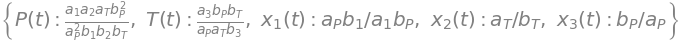

In [10]:
stst     = to_dict([X1,X2,X3,P,T],solve(Matrix([dx1,dx2,dx3,dP,dT]),[X1,X2,X3,P,T])[0])
display(stst)

Rescaling of the models variable by some of the parameters such that steady state equals to 1 (see methods)

In [11]:
simp     = {b1:a1,b2:a2,b3:a3,bp:ap,bt:at}
display(to_dict([X1,X2,X3,P,T],Matrix(solve(Matrix([dx1,dx2,dx3,dP,dT]),[X1,X2,X3,P,T])[0]).subs(simp)))

We note seperation of timescales, and solve the hormones quasi steady state - it is a function of the gland masses

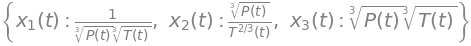

In [12]:
qst      = to_dict([X1,X2,X3],solve(Matrix([dx1,dx2,dx3]).subs(simp),[X1,X2,X3])[0])
display(qst)

We substitue the quasi steady state into the gland eqautions to find a system of 2 differeatnial equations:

In [13]:
mdeqs    = Matrix([Eq(P.diff(t),dP),
                   Eq(T.diff(t),dT)]).subs(qst).subs(simp)
display(mdeqs)

⎡d          ⎛              a_P       ⎞     ⎤
⎢──(P(t)) = ⎜-a_P + ─────────────────⎟⋅P(t)⎥
⎢dt         ⎜       3 ______ 3 ______⎟     ⎥
⎢           ⎝       ╲╱ P(t) ⋅╲╱ T(t) ⎠     ⎥
⎢                                          ⎥
⎢              ⎛    3 ______      ⎞        ⎥
⎢   d          ⎜a_T⋅╲╱ P(t)       ⎟        ⎥
⎢   ──(T(t)) = ⎜──────────── - a_T⎟⋅T(t)   ⎥
⎢   dt         ⎜   2/3            ⎟        ⎥
⎣              ⎝  T   (t)         ⎠        ⎦

We subtract 1 in order to model the relative change from the steady state

In [14]:
Y2       = Function('y_2')(t)
Y3       = Function('y_3')(t)

ysols = Matrix([Eq(Y2,qst[X2]-1),
                Eq(Y3,qst[X3]-1)])
display(ysols)

⎡            3 ______         ⎤
⎢            ╲╱ P(t)          ⎥
⎢    y₂(t) = ──────── - 1     ⎥
⎢             2/3             ⎥
⎢            T   (t)          ⎥
⎢                             ⎥
⎢        3 ______ 3 ______    ⎥
⎣y₃(t) = ╲╱ P(t) ⋅╲╱ T(t)  - 1⎦

The data is

In [15]:
xdat,ydat_y2,yerr_y2,n_y2 = get_stats_from_dataset_by_split('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',period=[5,80],split_k=2)
xdat,ydat_y3,yerr_y3,n_y3 = get_stats_from_dataset_by_split('T4_FREE','postpartum_change',period=[5,80],split_k=2)
xplot                     = np.arange(0,80,1).astype(int)

To fit the model, we simualte differential equations of the glands, with hormones at quasi steady-state

In [16]:
mdeqs_func = lambdify([P,T,ap,at],[mdeqs[0].args[1],mdeqs[1].args[1]])
ys_func    = lambdify([P,T],[ysols[0].args[1],ysols[1].args[1]])

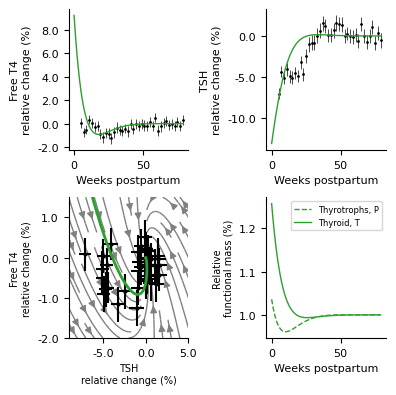

In [17]:
#### Fitting intial conditions, turnover rates from Yael's paper = 1/30 days for both glands
pm_yael_paper =  7*(30)**-1

def sim_mdeqs(y,t):
    P,T = y
    ap=at=pm_yael_paper
    return mdeqs_func(P,T,ap,at)

def obj_func(xdat,P0,T0):
    msols = odeint(sim_mdeqs,[P0,T0],np.arange(0,80))
    ysols = ys_func(msols[xdat.astype(int),0],msols[xdat.astype(int),1])
    return np.array(ysols).flat[:]

ydat              = np.append(ydat_y2.values,ydat_y3.values)
bounds            = ((0.8,0.8), (1.5,1.5))
popts,pcov        = curve_fit(obj_func,xdat,ydat,maxfev = 100000, p0 = [0.97,1.2], bounds=bounds)
ypred             = obj_func(xplot,*popts); y2_pred = ypred[:len(xplot)]; y3_pred = ypred[len(xplot):]

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    P0,T0    = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dP,dT    = mdeqs_func(P0,T0,pm_yael_paper,pm_yael_paper)*dt
    P1,T1  = P0+dP, T0+dT
    x21      = P1**(1/3) * T1**(-2/3)
    x31      = P1**(1/3) * T1**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
        
        
plt.figure(figsize=(4,4))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

ax1.plot(xplot,y3_pred,c=def_color[2],lw=1)
plot_thyroid('T4_FREE','postpartum_change',ax1)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=1); 
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=2,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)

msols = odeint(sim_mdeqs,[popts[0],popts[1]],xplot) ; P_pred = msols[xplot,0]; T_pred =msols[xplot,1]
ax4.plot(xplot,msols[:,0],lw=1,ls='--',c=def_color[2])
ax4.plot(xplot,msols[:,1],lw=1,c=def_color[2])

ax4.set_ylabel('Relative\nfunctional mass (%)',fontsize=7)
ax4.set_xlabel('Weeks postpartum',fontsize=8)
ax4.legend(['Thyrotrophs, P','Thyroid, T'],fontsize=6)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
plt.savefig('thyroid_fit_yael_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

gland_mass_yael_pred = pd.DataFrame(np.array([y2_pred,y3_pred,P_pred,T_pred]).T,columns=['x2','x3','P','T'],index=xplot)

⎡          d                                              ⎤
⎢          ──(y₁(t) + 1) = -a₁⋅y₁(t) - a₁⋅y₃(t)           ⎥
⎢          dt                                             ⎥
⎢                                                         ⎥
⎢d                                                        ⎥
⎢──(y₂(t) + 1) = a₂⋅Z₁(t) + a₂⋅y₁(t) - a₂⋅y₂(t) - a₂⋅y₃(t)⎥
⎢dt                                                       ⎥
⎢                                                         ⎥
⎢     d                                                   ⎥
⎢     ──(y₃(t) + 1) = a₃⋅Z₂(t) + a₃⋅y₂(t) - a₃⋅y₃(t)      ⎥
⎢     dt                                                  ⎥
⎢                                                         ⎥
⎢               d                                         ⎥
⎢               ──(Z₁(t) + 1) = -a_P⋅y₃(t)                ⎥
⎢               dt                                        ⎥
⎢                                                         ⎥
⎢                d                      

⎡d              ⎛Z₁(t)   Z₂(t)⎞ ⎤
⎢──(Z₁(t)) = -p⋅⎜───── + ─────⎟ ⎥
⎢dt             ⎝  3       3  ⎠ ⎥
⎢                               ⎥
⎢d             ⎛Z₁(t)   2⋅Z₂(t)⎞⎥
⎢──(Z₂(t)) = p⋅⎜───── - ───────⎟⎥
⎣dt            ⎝  3        3   ⎠⎦

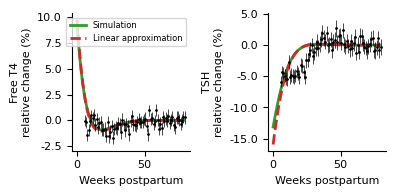

In [18]:
#We linearize the model - relative change from the steady state is denoted as  𝑦#
lin_deqs = Matrix([Eq(X1.diff(t),dx1.diff(X1).subs(stst)*(X1-1) + dx1.diff(X2).subs(stst)*(X2-1) + dx1.diff(X3).subs(stst)*(X3-1) + dx1.diff(P).subs(stst)*(P-1) + dx1.diff(T).subs(stst)*(T-1)),
                   Eq(X2.diff(t),dx2.diff(X1).subs(stst)*(X1-1) + dx2.diff(X2).subs(stst)*(X2-1) + dx2.diff(X3).subs(stst)*(X3-1) + dx2.diff(P).subs(stst)*(P-1) + dx2.diff(T).subs(stst)*(T-1)),
                   Eq(X3.diff(t),dx3.diff(X1).subs(stst)*(X1-1) + dx3.diff(X2).subs(stst)*(X2-1) + dx3.diff(X3).subs(stst)*(X3-1) + dx3.diff(P).subs(stst)*(P-1) + dx3.diff(T).subs(stst)*(T-1)),
                   Eq(P.diff(t),dP.diff(X1).subs(stst)*(X1-1) + dP.diff(X2).subs(stst)*(X2-1) + dP.diff(X3).subs(stst)*(X3-1) + dP.diff(P).subs(stst)*(P-1) + dP.diff(T).subs(stst)*(T-1)),
                   Eq(T.diff(t),dT.diff(X1).subs(stst)*(X1-1) + dT.diff(X2).subs(stst)*(X2-1) + dT.diff(X3).subs(stst)*(X3-1) + dT.diff(P).subs(stst)*(P-1) + dT.diff(T).subs(stst)*(T-1))]).subs(simp)
                
Y1       = Function('y_1')(t)
Y2       = Function('y_2')(t)
Y3       = Function('y_3')(t)
Z1       = Function('Z_1')(t)
Z2       = Function('Z_2')(t)

lin_subs = {X1:Y1+1,X2:Y2+1,X3:Y3+1,P:Z1+1,T:Z2+1}
lin_deqs = lin_deqs.subs(lin_subs)
display(lin_deqs)

lqst  = solve([lin_deqs[0].args[1],lin_deqs[1].args[1],lin_deqs[2].args[1]],[Y1,Y2,Y3])
display(lqst)

zdeqs = Matrix([Eq(Z1.diff(t),lin_deqs[3].args[1].subs(lqst)),
               Eq(Z2.diff(t),lin_deqs[4].args[1].subs(lqst))]).subs(ap,p).subs(at,p)
display(zdeqs)

Z10,Z20   = symbols('Z_{1_0},Z_{2_0}')
ICS       = {Z1.subs(t,0):Z10,Z2.subs(t,0):Z20}
lin_zsols = Matrix(dsolve(zdeqs,ics=ICS))
zsubs     = {Z1:lin_zsols[0].args[1],Z2:lin_zsols[1].args[1]}
tsh_sol   = lqst[Y2].subs(zsubs)
t4_sol    = lqst[Y3].subs(zsubs)

y2_linear = np.array([tsh_sol.subs({Z10:popts[0]-1,Z20:popts[1]-1,p:pm_yael_paper,t:x}) for x in xplot]).astype(float)
y3_linear = np.array([t4_sol.subs({Z10:popts[0]-1,Z20:popts[1]-1,p:pm_yael_paper,t:x}) for x in xplot]).astype(float)

plt.figure(figsize=(4,2))
ax1,ax2 = plt.subplot(121),plt.subplot(122)
ax1.plot(xplot,y3_pred,c=def_color[2],lw=2,zorder=-5)
ax1.plot(xplot,y3_linear,c=def_color[3],lw=2,ls='--',zorder=-5)
ax1.legend(['Simulation','Linear approximation'],fontsize=6)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=2,zorder=-5)
ax2.plot(xplot,y2_linear,c=def_color[3],lw=2,ls='--',zorder=-5)

plot_thyroid('T4_FREE','postpartum_change',ax1,split_k=1)
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2,split_k=1)
remove_top_right_frame([ax1,ax2])
plt.tight_layout(); 
plt.savefig('linear_model_comparison.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()


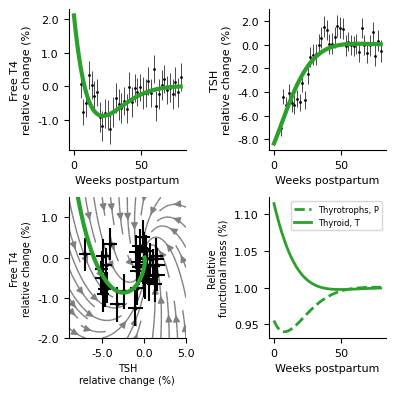

In [19]:
##### Fitting intial conditions and turnover rates
mdeqs_func = lambdify([P,T,ap,at],[mdeqs[0].args[1],mdeqs[1].args[1]])
ys_func    = lambdify([P,T],[ysols[0].args[1],ysols[1].args[1]])

def sim_mdeqs(y,t,ap,at):
    P,T = y
    return mdeqs_func(P,T,ap,at)

def obj_func(xdat,P0,T0,ap,at):
    msols = odeint(sim_mdeqs,[P0,T0],np.arange(0,80),args=(ap,at))
    ysols = ys_func(msols[xdat.astype(int),0],msols[xdat.astype(int),1])
    return np.array(ysols).flat[:]

ydat              = np.append(ydat_y2.values,ydat_y3.values)
bounds            = ((0.8,0.8,0,0), (1.2,1.2,1,1))
popts,pcov        = curve_fit(obj_func,xdat,ydat,maxfev = 100000, p0 = [0.97,1.2,0.12,0.12], bounds=bounds)

xplot             = np.arange(0,80,1).astype(int)
ypred             = obj_func(xplot,*popts); y2_pred = ypred[:len(xplot)]; y3_pred = ypred[len(xplot):]

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = m11**(1/3) * m21**(-2/3)
    x31      = m11**(1/3) * m21**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
        
plt.figure(figsize=(4,4))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

ax1.plot(xplot,y3_pred,c=def_color[2],lw=3)
plot_thyroid('T4_FREE','postpartum_change',ax1)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=3); 
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)

msols = odeint(sim_mdeqs,[popts[0],popts[1]],xplot,args=(popts[2],popts[3])) ; P_pred = msols[xplot,0]; T_pred =msols[xplot,1]
ax4.plot(xplot,msols[:,0],lw=2,ls='--',c=def_color[2])
ax4.plot(xplot,msols[:,1],lw=2,c=def_color[2])
ax4.set_ylabel('Relative\nfunctional mass (%)',fontsize=7)
ax4.set_xlabel('Weeks postpartum',fontsize=8)
ax4.legend(['Thyrotrophs, P','Thyroid, T'],fontsize=6)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
plt.savefig('thyroid_fit_turnover_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

gland_mass_fit_pred = pd.DataFrame(np.array([y2_pred,y3_pred,P_pred,T_pred]).T,columns=['x2','x3','P','T'],index=xplot)

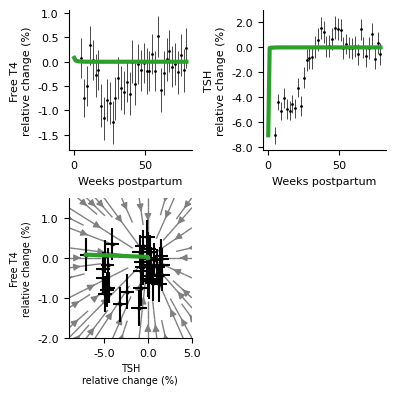

In [20]:
#### The minimal model without gland mass change
dx1      = b1/X3      - a1*X1  
dx2      = b2*P*X1/X3 - a2*X2       
dx3      = b3*T*X2    - a3*X3 
min_pars = {b1:1/6,b2:1/60,b3:1/(7*60*24),a1:1/6,a2:1/60,a3:1/(7*60*24),P:1,T:1}

minimal_xdeqs = Matrix([dx1,dx2,dx3]).subs(min_pars)
minimal_func  = lambdify([X1,X2,X3],minimal_xdeqs)

x2_ic = ydat_y2.iloc[0] + 1
x3_ic = ydat_y3.iloc[0] + 1
x1_ic = solve(dx1,X1)[0].subs(min_pars).subs(X3,x3_ic)

def sim_fast_eq(y,t):
    return minimal_func(*y).flat[:]

ics           = [x1_ic,x2_ic,x3_ic]
minimal_x_sol = odeint(sim_fast_eq,ics,xplot*60*24)

y2_pred = minimal_x_sol[:,1] - 1
y3_pred = minimal_x_sol[:,2] - 1

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = 1**(1/3) * 1**(-2/3)
    x31      = 1**(1/3) * 1**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
    

plt.figure(figsize=(4,4))
ax1,ax2,ax3 = plt.subplot(221),plt.subplot(222),plt.subplot(223)
        
ax1.plot(xplot,y3_pred,c=def_color[2],lw=3)
plot_thyroid('T4_FREE','postpartum_change',ax1)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=3); 
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout();
plt.savefig('thyroid_fit_minimal_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

minimal_model_pred = pd.DataFrame(np.array([y2_pred,y3_pred,np.ones_like(y2_pred),np.ones_like(y2_pred)]).T,columns=['x2','x3','P','T'],index=xplot)

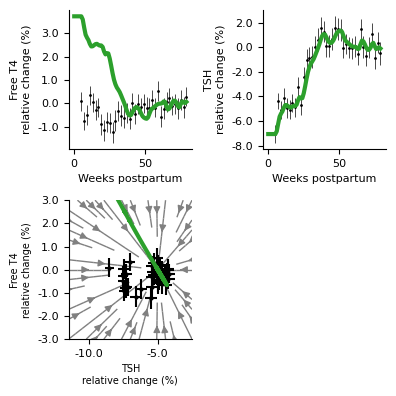

In [21]:
#### Minimal model with one slow process
#### In minimal model with parameters that changes slowly we can assume that the hormone are at quasi steady state, wihtout gland masses. In this case, there is fixed relation between TSH and T4.
#### Based on the quasi steady state, I fit a timecourse for $b_3$ (T4 production rate) based on TSH data and plot both hormones

l = symbols('\lambda')

dx1      = b1/X3       - a1*X1  
dx2      = b2*P*X1/X3 - a2*X2       
dx3      = b3*T*X2    - a3*X3 
Xqst     = Matrix(solve([dx1,dx2,dx3],[X1,X2,X3])[0]).subs({P:1,T:1})

b3_fit_x2= lambdify(l,solve(Eq(Xqst[1].subs({b1:1,b2:1,a3:1,a1:1,a2:1}),l),b3)[0])(ydat_y2 + 1)
b3_func_x2  = interp1d(b3_fit_x2.index,b3_fit_x2.values,bounds_error=False,fill_value =b3_fit_x2.iloc[0])

min_pars = {b1:1/6,b2:1/60,a1:1/6,a2:1/60,a3:1/(7*60*24),P:1,T:1}

minimal_xdeqs     = Matrix([dx1,dx2,dx3]).subs(min_pars)
minimal_func_wb3  = lambdify([X1,X2,X3,b3],minimal_xdeqs)

def sim_fast_eq_b3_fit_x2(y,t):
    b3_ = (1/(7*60*24)) * b3_func_x2(t/(60*24))
    return minimal_func_wb3(*y,b3_).flat[:]

ics           = np.array(Xqst.subs({b1:1,b2:1,a3:1,a1:1,a2:1,b3:b3_func_x2(x[0])})).astype(float).flat[:]
minimal_x_sol = odeint(sim_fast_eq_b3_fit_x2,ics,xplot*60*24)

y2_pred = minimal_x_sol[:,1] - 1
y3_pred = minimal_x_sol[:,2] - 1

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = 1**(1/3) * 1**(-2/3)
    x31      = 1**(1/3) * 1**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.13, 0.05]
y3_lim   = [-0.03, 0.03]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
        
plt.figure(figsize=(4,4))
ax1,ax2,ax3 = plt.subplot(221),plt.subplot(222),plt.subplot(223)
        
ax1.plot(xplot,y3_pred,c=def_color[2],lw=3)
plot_thyroid('T4_FREE','postpartum_change',ax1)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=3); 
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout();
plt.savefig('thyroid_fit_TSH_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

minimal_model_b3_fit_x2_pred = pd.DataFrame(np.array([y2_pred,y3_pred,np.ones_like(y2_pred),np.ones_like(y2_pred)]).T,columns=['x2','x3','P','T'],index=xplot)

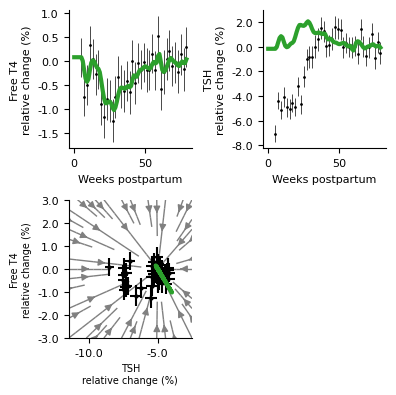

In [22]:
l = symbols('\lambda')

dx1      = b1/X3       - a1*X1  
dx2      = b2*P*X1/X3 - a2*X2       
dx3      = b3*T*X2    - a3*X3 
Xqst     = Matrix(solve([dx1,dx2,dx3],[X1,X2,X3])[0]).subs({P:1,T:1})

b3_fit_x3= lambdify(l,solve(Eq(Xqst[2].subs({b1:1,b2:1,a3:1,a1:1,a2:1}),l),b3)[0])(ydat_y3 + 1)
b3_func_x3  = interp1d(b3_fit_x3.index,b3_fit_x3.values,bounds_error=False,fill_value =b3_fit_x3.iloc[0])

min_pars = {b1:1/6,b2:1/60,a1:1/6,a2:1/60,a3:1/(7*60*24),P:1,T:1}

minimal_xdeqs     = Matrix([dx1,dx2,dx3]).subs(min_pars)
minimal_func_wb3  = lambdify([X1,X2,X3,b3],minimal_xdeqs)

def sim_fast_eq_b3_fit_x3(y,t):
    b3_ = (1/(7*60*24)) * b3_func_x3(t/(60*24))
    return minimal_func_wb3(*y,b3_).flat[:]

ics           = np.array(Xqst.subs({b1:1,b2:1,a3:1,a1:1,a2:1,b3:b3_func_x3(x[0])})).astype(float).flat[:]
minimal_x_sol = odeint(sim_fast_eq_b3_fit_x3,ics,xplot*60*24)

y2_pred = minimal_x_sol[:,1] - 1
y3_pred = minimal_x_sol[:,2] - 1

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = 1**(1/3) * 1**(-2/3)
    x31      = 1**(1/3) * 1**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.13, 0.05]
y3_lim   = [-0.03, 0.03]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
        
plt.figure(figsize=(4,4))
ax1,ax2,ax3 = plt.subplot(221),plt.subplot(222),plt.subplot(223)
        
ax1.plot(xplot,y3_pred,c=def_color[2],lw=3)
plot_thyroid('T4_FREE','postpartum_change',ax1)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=3); 
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout();
plt.savefig('thyroid_fit_T4_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

minimal_model_b3_fit_x3_pred = pd.DataFrame(np.array([y2_pred,y3_pred,np.ones_like(y2_pred),np.ones_like(y2_pred)]).T,columns=['x2','x3','P','T'],index=xplot)

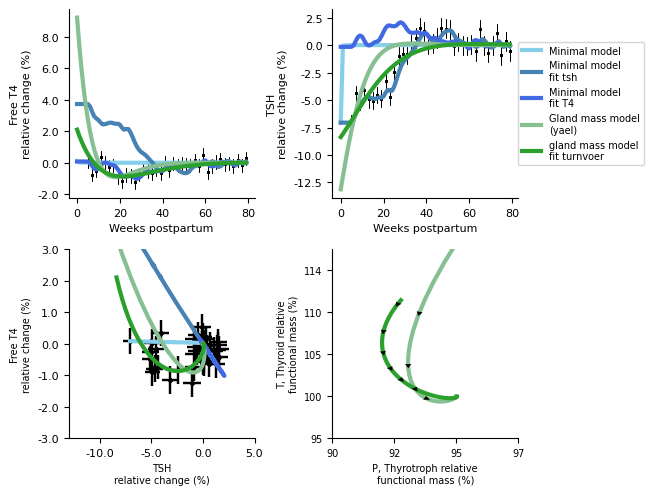

,pearson r,pval,sse
Minimal model,0.511741,2.304977e-06,0.027309
Minimal model\nfit tsh,0.816260,2.608254e-19,0.013746
Minimal model\nfit T4,-0.163812,1.573661e-01,0.035167
Gland mass model\n(yael),0.726275,1.131109e-13,0.011862
gland mass model\nfit turnvoer,0.900883,1.544001e-28,0.004521


In [23]:
comparison_dfs = [minimal_model_pred,minimal_model_b3_fit_x2_pred,minimal_model_b3_fit_x3_pred,gland_mass_yael_pred,gland_mass_fit_pred]
fit_summery = []
plt.figure(figsize=(7,5))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)
plotcolors = ['skyblue','steelblue','royalblue','#86bf91',def_color[2]]
for i,df in enumerate(comparison_dfs):
    y2_pred= df['x2'].values
    y3_pred= df['x3'].values
    P_pred = df['P'].values
    T_pred = df['T'].values

    ax1.plot(xplot,y3_pred,c=plotcolors[i],lw=3); plot_thyroid('T4_FREE','postpartum_change',ax1)
    ax2.plot(xplot,y2_pred,c=plotcolors[i],lw=3); plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)

    ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
    ax3.set_xlim(y2_lim)
    ax3.set_ylim(y3_lim)
    ax3.plot(y2_pred,y3_pred,lw=3,c=plotcolors[i],zorder=4)
    ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
    ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
    ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
    ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)

    ax4.plot(P_pred,T_pred,lw=3,c=plotcolors[i])
    ax4.set_xlabel('P, Thyrotroph relative\nfunctional mass (%)',fontsize=7)
    ax4.set_ylabel('T, Thyroid relative\nfunctional mass (%)',fontsize=7)
    for i in [0,5,10,15,20]:
        ax4.arrow(P_pred[i], T_pred[i], P_pred[i+1]-P_pred[i], T_pred[i+1]-T_pred[i], shape='full', lw=0, length_includes_head=True,width=0, head_length=.005, head_width=.005,zorder=4,color='k')

    ax4.set_ylim([0.95,1.175])
    ax4.set_xlim([0.9,1.05])

    ax4.set_xticklabels([int(tick*100) for tick in ax4.get_xticks()],fontsize=7)
    ax4.set_yticklabels([int(tick*100) for tick in ax4.get_yticks()],fontsize=7)
        
    pearson_corr = stats.pearsonr(np.array([y2_pred[5::2]] + [y3_pred[5::2]]).flat[:],np.array([ydat_y2] + [ydat_y3]).flat[:])
    sse          = np.sum((y2_pred[5::2] - ydat_y2)**2) + np.sum((y3_pred[5::2] - ydat_y3)**2)
    fit_summery.append(list(pearson_corr) + [sse])
ax2.legend(['Minimal model','Minimal model\nfit tsh','Minimal model\nfit T4','Gland mass model\n(yael)','gland mass model\nfit turnvoer'],fontsize=7,loc='center right',bbox_to_anchor=(1.7, 0.5))
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
plt.savefig('postpartum_models_comparison.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

display(pd.DataFrame(fit_summery,columns=['pearson r','pval','sse'],index = ['Minimal model','Minimal model\nfit tsh','Minimal model\nfit T4','Gland mass model\n(yael)','gland mass model\nfit turnvoer']))

Bootstrap data to estimate CI

In [24]:
popts_bs = []
for i in tqdm(range(1000)):
    ydat_y2_bs = ydat_y2 + np.random.randn(len(yerr_y2))*yerr_y2
    ydat_y3_bs = ydat_y3 + np.random.randn(len(yerr_y3))*yerr_y3
    ydat       = np.append(ydat_y2_bs.values,ydat_y3_bs.values)
    popts      = curve_fit(obj_func,xdat,ydat,maxfev = 100000, p0 = [0.97,1.2,0.12,0.12], bounds=bounds)[0]
    popts_bs.append(popts)
popt_df = pd.DataFrame(popts_bs,columns=['P0','T0','ap','at'])

print('T0',(np.array([np.percentile(popt_df.T0,50),np.percentile(popt_df.T0,5),np.percentile(popt_df.T0,95)]) - 1)*100)
print('P0',(np.array([np.percentile(popt_df.P0,50),np.percentile(popt_df.P0,5),np.percentile(popt_df.P0,95)]) - 1)*100)
print('at',np.array([np.percentile(7/popt_df['at'],50),np.percentile(7/popt_df['at'],5),np.percentile(7/popt_df['at'],95)]))
print('ap',np.array([np.percentile(7/popt_df['ap'],50),np.percentile(7/popt_df['ap'],5),np.percentile(7/popt_df['ap'],95)]))

  0%|          | 0/1000 [00:00<?, ?it/s]

T0 [11.45168253 10.1367158  12.83359498]
P0 [-4.49631926 -5.82051536 -2.95595985]
at [85.19146711 76.63655629 95.97440844]
ap [30.3179095  25.49446596 36.37473363]


In [25]:
def obj_func_full(xdat,P0,T0,ap,at):
    msols = odeint(sim_mdeqs,[P0,T0],np.arange(0,80),args=(ap,at))
    ysols = ys_func(msols[xdat.astype(int),0],msols[xdat.astype(int),1])
    return np.array(ysols).flat[:],np.array(msols).T.flat[:]

y2_bs = []
y3_bs = []
P_bs  = []
T_bs  = []
for popts in popts_bs:
    pred   = obj_func_full(xplot,*popts) 
    y2_bs.append(pred[0][:len(xplot)])
    y3_bs.append(pred[0][len(xplot):])
    P_bs.append(pred[1][:len(xplot)])
    T_bs.append(pred[1][len(xplot):])

y2_bs = np.array(y2_bs)
y3_bs = np.array(y3_bs)
P_bs = np.array(P_bs)
T_bs = np.array(T_bs)

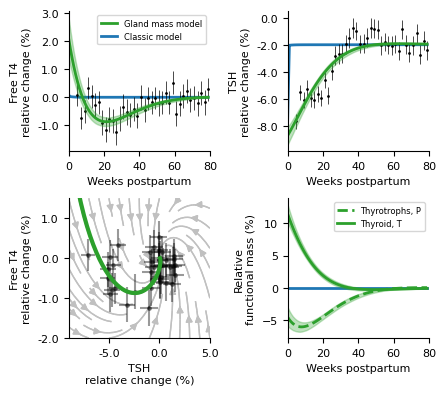

In [26]:
##### Plot for paper
plt.figure(figsize=(4.5,4))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

gland_mass_fit_pred.x3.plot(ax=ax1,c=def_color[2],lw=2)
minimal_model_pred.x3.plot(ax=ax1,c=def_color[0],lw=2,zorder=-4)
plot_thyroid('T4_FREE','postpartum_change',ax1)
ax1.set_xlim([0,80]); ax1.legend(['Gland mass model','Classic model'],fontsize=6)
ax1.fill_between(xplot,np.percentile(y3_bs,5,axis=0),np.percentile(y3_bs,95,axis=0),color=def_color[2],alpha=0.3)

gland_mass_fit_pred.x2.plot(ax=ax2,c=def_color[2],lw=2)
minimal_model_pred.x2.plot(ax=ax2,c=def_color[0],lw=2,zorder=-4)
plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2)
ax2.set_xlim([0,80])
ax2.fill_between(xplot,np.percentile(y2_bs,5,axis=0),np.percentile(y2_bs,95,axis=0),color=def_color[2],alpha=0.3)

(100*(gland_mass_fit_pred['P']-1)).plot(ax=ax4,c=def_color[2],lw=2,ls='--')
(100*(gland_mass_fit_pred['T']-1)).plot(ax=ax4,c=def_color[2],lw=2)
(100*(minimal_model_pred-1)).P.plot(ax=ax4,c=def_color[0],lw=2,zorder=-4)
ax4.set_xlim([0,80])
ax4.set_ylabel('Relative\nfunctional mass (%)')
ax4.set_xlabel('Weeks postpartum')
ax4.legend(['Thyrotrophs, P','Thyroid, T'],fontsize=6)
ax4.fill_between(xplot,np.percentile(100*(P_bs-1),5,axis=0),np.percentile(100*(P_bs-1),95,axis=0),color=def_color[2],alpha=0.3)
ax4.fill_between(xplot,np.percentile(100*(T_bs-1),5,axis=0),np.percentile(100*(T_bs-1),95,axis=0),color=def_color[2],alpha=0.3)

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = m11**(1/3) * m21**(-2/3)
    x31      = m11**(1/3) * m21**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='silver', linewidth=1)
ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='silver', linewidth=1)
ax3.errorbar(ydat_y2[::],ydat_y3[::],xerr=yerr_y2[::],yerr=yerr_y3[::],c='k',fmt='o',markersize=2.5,linewidth=1.5,alpha=0.4)

ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(gland_mass_fit_pred.x2,gland_mass_fit_pred.x3,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)')


remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
plt.savefig('thyroid_postpartum_figures.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()


## The entire HPT axis dynamics can be explained by the gland mass model with minimal assumptions 

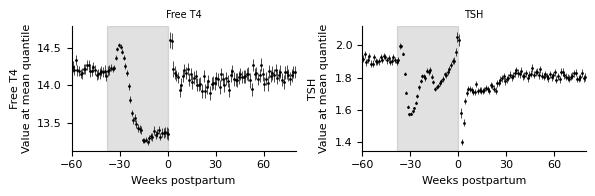

In [45]:
plt.figure(figsize=(6,2))
ax1,ax2= plt.subplot(121),plt.subplot(122)

plot_thyroid('T4_FREE','value_at_quantile',ax1,period=[-60, 80],split_k=1)
ax1.set_title(metadata.loc['T4_FREE']['Nice name'] ,fontsize=7)
ax1.set_xlim([-60,80])
ax1.set_xticks(np.arange(-60,80,30))

plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','value_at_quantile',ax2,period=[-60, 80],split_k=1)
ax2.set_title(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] ,fontsize=7)
ax2.set_xlim([-60,80])
ax2.set_xticks(np.arange(-60,80,30))

[ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2]]
remove_top_right_frame([ax1,ax2,])
plt.tight_layout()
plt.show()

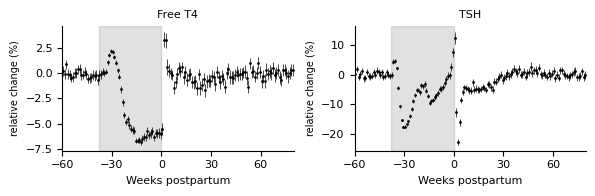

In [48]:
plt.figure(figsize=(6,2))
ax1,ax2= plt.subplot(121),plt.subplot(122)

plot_thyroid('T4_FREE','norm_baselines',ax1,period=[-60, 80],split_k=1)
ax1.set_ylabel('relative change (%)' ,fontsize=7)
ax1.set_xlim([-60,80])
ax1.set_xticks(np.arange(-60,80,30))
ax1.set_title(metadata.loc['T4_FREE']['Nice name'])

plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','norm_baselines',ax2,period=[-60, 80],split_k=1)
ax2.set_ylabel('relative change (%)' ,fontsize=7)
ax2.set_xlim([-60,80])
ax2.set_xticks(np.arange(-60,80,30))
ax2.set_title(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'])

[ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2]]
remove_top_right_frame([ax1,ax2,])
plt.tight_layout()
plt.show()

In [29]:
# hCG values obtained from "Regulation of Maternal Thyroid during Pregnancy" by Glinoer (1990) 
# Values were sampled from fig 6. using 'WebPlotDigitizer'
hcg = np.array([0                , 0,
                5.481179403206124, 23.21957884416816,
                7.600308722452256, 35.10956518111368,
                9.562052169922506, 43.73043106415376,
                11.530574995567328, 35.07660697337268,
                13.6031873507233, 28.266773746075774,
                15.570250002607448, 19.025959803502325,
                17.542110368276678, 11.713826802532346,
                19.475901918042528, 9.098029808404334,
                21.567913724590365, 10.086776040634547,
                23.505460006883666, 8.980381522544036,
                25.544801259921346, 8.795565243692572,
                27.934688513647398, 9.530241241564887,
                29.525026335276745, 8.846045536561704,
                31.318119713388743, 9.669583537583826,
                33.45800435966164, 9.903211339292234,
                35.45260171674714, 11.731348887660488])

# Values were corrected by hand to approxmiate the data using simple interpolation
hcg = np.array([0                , 0 ,
                2                , 0 ,
                10               , 44,
                20               , 9 ,
                40               , 9])

hcg      = np.reshape(hcg,(int(len(hcg)/2),2))
hcg_func = interp1d(hcg[:,0],hcg[:,1],bounds_error =False,fill_value=9)

To simulate pregnancy we assumed an increasing challenge on thyroid hormone production, and hCG dynamics obtained from the literature

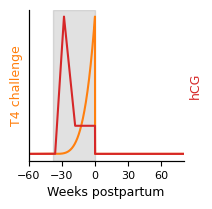

In [30]:
def get_gestational_challenge(t,g,q):
    if t < 22*7*24:   # pre-pregnancy
        q_ = 1
        h_ = 0
    elif t < 60*7*24: # pregnancy  
        q_ = (1+q*((t-22*7*24)/(38*7*24))**4)
        h_ = hcg_func((t-22*7*24)/(7*24))
    else:             # post-partum
        q_ = 1
        h_ = 0
    return q_,g*h_

time       = np.arange(0,(22+38+80)*7*24,1)
challenges =  pd.DataFrame([get_gestational_challenge(t,0.3,0.3) for t in time],columns=['q','hcg'],index=time/(24*7)-60).astype(float)

plt.figure(figsize=(2,2))
ax1 = plt.subplot(111)
ax2 = ax1.twinx()


challenges.q.plot(ax=ax1,c=def_color[1])  ; ax1.set_ylabel('T4 challenge',fontsize=9,color=def_color[1]); ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_xlim([-60,80])
challenges.hcg.plot(ax=ax2,c=def_color[3]); ax2.set_ylabel('hCG',fontsize=9,color=def_color[3])         ; ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_xlim([-60,80])
ax1.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
ax1.set_xlabel('Weeks postpartum',fontsize=9); ax1.set_xticks(np.arange(-60,80,30))
remove_top_right_frame([ax1,ax2])
plt.savefig('hpt_model_challenge.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

In [31]:
# def plot_sim_results(sim_res1):
#     plt.figure(figsize=(5,5))

#     ax1,ax2,ax3,ax4,ax5,ax6 = plt.subplot(321),plt.subplot(322),plt.subplot(323),plt.subplot(324),plt.subplot(325),plt.subplot(326)
   
#     plot_thyroid('T4_FREE','postpartum_change',ax1,period=[-60,80])
#     plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','postpartum_change',ax2,period=[-60,80])

#     100*(sim_res1['x3']-1).plot(ax=ax3,c='k'); ax3.set_title(metadata.loc['T4_FREE']['Nice name'])
#     100*(sim_res1['x2']-1).plot(ax=ax4,c='k'); ax4.set_title(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'])
#     100*(sim_res1['P']-1).plot(ax=ax5,c='k'); ax5.set_title('Pituitary')
#     100*(sim_res1['T']-1).plot(ax=ax6,c='k'); ax6.set_title('Thyroid')

#     ax1.set_ylabel('Relative change (%)');
#     ax3.set_ylabel('Relative change (%)');
#     ax5.set_ylabel('Relative change (%)');
#     ax5.set_xlabel('Weeks postpartum');
#     ax6.set_xlabel('Weeks postpartum');
#     [ax.set_xlim([-60,80]) for ax in [ax1,ax3,ax4,ax5,ax6]]

#     for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
#         ax.set_xticks(np.arange(-60,100,20))
#         ax.set_xlim([-60,80])
#         ax.set_yticklabels([int(tick*100) for tick in ax.get_yticks()],fontsize=7)

#     [ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2,ax3,ax4,ax5,ax6]]
    
#     remove_top_right_frame([ax1,ax2,ax3,ax4,ax5,ax6]) 
#     plt.tight_layout(); plt.show()

In [32]:
q,g,h    = symbols('q,g,h',positive=True)
dx1      = b1/X3          - a1*X1  
dx2      = b2*P*X1/X3     - a2*X2       
dx3      = b3*T*(X2+h)    - q*a3*X3
dP       = P*(bp/X3       - ap)
dT       = T*(bt*(X2+h)   - at)

simp     = {a1:b1,a2:b2,a3:b3,bp:ap,bt:at}       
pars     = {b1:10,b2:1,b3:1/(7*24),ap:1/(31*24),at:1/(85*24)} # parameters on the time scale of 1 hour

all_odes_func = lambdify([X1,X2,X3,P,T,q,h],Matrix([dx1,dx2,dx3,dP,dT]).subs(simp).subs(pars))

def sim_all_odes(y,t,gland_mass_change=True,g=0.5/30,q=0.5):
    
    q_,h_             = get_gestational_challenge(t,g,q)
    X1,X2,X3,P,T      = y
    dx1,dx2,dx3,dP,dT = all_odes_func(X1,X2,X3,P,T,q_,h_).flat[:]
    
    if gland_mass_change:
        return np.array([dx1,dx2,dx3,dP,dT]).astype(float)
    else:
        return np.array([dx1,dx2,dx3,0,0]).astype(float)

ic       = nsolve(Matrix([dx1,dx2,dx3,dP,dT]).subs(simp).subs(pars).subs(q,1).subs(h,0),[X1,X2,X3,P,T],[1,1,1,1,1])
ic       = np.array(ic).astype(float).flat[:] 
time     = np.arange(0,(22+38+80)*7*24,1)

In [33]:
x,t4_data,e,n  = get_stats_from_dataset_by_split('T4_FREE','norm_baselines',split_k=1)
x,tsh_data,e,n = get_stats_from_dataset_by_split('TSH_THYROID_STIMULATING_HORMONE','norm_baselines',split_k=1)
t4_data        = t4_data+1#.drop(index=[-1,1,3])
tsh_data       = tsh_data+1#.drop(index=[-1,1,3])

I normalize each period to the baseline, in order to have similar baselines that are calibrated to 1

In [34]:
def fit_brute_gland_mass(pars):
    g,q      = pars
    sim_res  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(True,g,q)),columns=['x1','x2','x3','P','T'],index=time/(24*7)-60)/ic
    tsh_pred = sim_res.x2.loc[tsh_data.index.values]
    t4_pred  = sim_res.x3.loc[t4_data.index.values]
    return np.sum((tsh_pred - tsh_data)**2) + np.sum((4*t4_pred - 4*t4_data)**2) # I weight t4 data to make the fit evan for both tests

def fit_brute_constant_glands(pars):
    g,q      = pars
    sim_res  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(False,g,q)),columns=['x1','x2','x3','P','T'],index=time/(24*7)-60)/ic
    tsh_pred = sim_res.x2.loc[tsh_data.index.values]
    t4_pred  = sim_res.x3.loc[t4_data.index.values]
    return np.sum((tsh_pred - tsh_data)**2) + np.sum((4*t4_pred - 4*t4_data)**2) # I weight t4 data to make the fit evan for both tests

g_range = (0,1)
q_range = (0,1)
bounds  = (g_range,q_range)

In [35]:
best_pars_gland_mass= brute(fit_brute_gland_mass,bounds,Ns = 20) 
best_pars_constant  = brute(fit_brute_constant_glands,bounds,Ns = 20) 

In [36]:
best_pars_gland_mass

array([0.00391905, 0.27950594])

In [37]:
fit_res_gland_mass  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(True,best_pars_gland_mass[0],best_pars_gland_mass[1])),columns=['x1','x2','x3','m1','m2'],index=time/(24*7)-60)/ic - 1
fit_res_const_mass  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(False,best_pars_constant[0],best_pars_constant[1])),columns=['x1','x2','x3','m1','m2'],index=time/(24*7)-60)/ic - 1

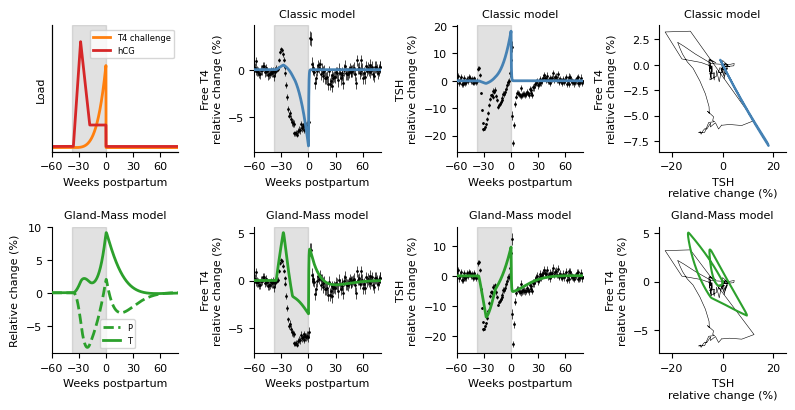

In [38]:
plt.figure(figsize=(8,6))

ax4,ax1,ax2,ax3= plt.subplot(345),plt.subplot(346),plt.subplot(347),plt.subplot(348)

plot_thyroid('T4_FREE','norm_baselines',ax1,period=[-60, 80],split_k=1)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nrelative change (%)')
(100*fit_res_const_mass).x3.plot(ax=ax1,c='steelblue',lw=2,zorder=5)
ax1.set_xlim([-60,80])
ax1.set_xticks(np.arange(-60,80,30))
ax1.set_title('Classic model')

plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','norm_baselines',ax2,period=[-60, 80],split_k=1)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nrelative change (%)')
(100*fit_res_const_mass.x2).plot(ax=ax2,c='steelblue',lw=2,zorder=5)
ax2.set_xlim([-60,80])
ax2.set_xticks(np.arange(-60,80,30))
ax2.set_title('Classic model')

ax3.plot(100*(tsh_data.loc[-40:50]-1),100*(t4_data.loc[-40:50]-1),c='k',lw=0.4)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nrelative change (%)')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nrelative change (%)' )
ax3.plot((100*fit_res_const_mass).x2,(100*fit_res_const_mass).x3,c='steelblue',zorder=5)
ax3.set_title('Classic model')
ax3.set_xlim([-25,25])

ax4t = ax4.twinx()
challenges.q.plot(ax=ax4,c=def_color[1],lw=2)   ; ax4.set_xticks([]); ax4.set_yticks([]); ax4.set_xlim([-60,80])
challenges.hcg.plot(ax=ax4t,c=def_color[3],lw=2); ax4t.set_xticks([]); ax4t.set_yticks([]); ax4t.set_xlim([-60,80])
ax4.set_ylim([ax4.get_ylim()[0],ax4.get_ylim()[1]*1.1])
ax4t.set_ylim([ax4t.get_ylim()[0],ax4t.get_ylim()[1]*1.1])

ax4.set_ylabel('Load',color='k'); 

custom_lines = [Line2D([0], [0], color=def_color[1], lw=2),
                Line2D([0], [0], color=def_color[3], lw=2)]

ax4.legend(custom_lines, ['T4 challenge', 'hCG'],fontsize=6)
ax4.set_xlabel('Weeks postpartum'); ax4.set_xticks(np.arange(-60,80,30))
[ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2,ax4]]
remove_top_right_frame([ax1,ax2,ax3,ax4,ax4t])

######
ax4,ax1,ax2,ax3= plt.subplot(3,4,9),plt.subplot(3,4,10),plt.subplot(3,4,11),plt.subplot(3,4,12)

plot_thyroid('T4_FREE','norm_baselines',ax1,period=[-60, 80],split_k=1)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nrelative change (%)')
(100*fit_res_gland_mass).x3.plot(ax=ax1,c=def_color[2],lw=2,zorder=5)
ax1.set_xlim([-60,80])
ax1.set_xticks(np.arange(-60,80,30))
ax1.set_title('Gland-Mass model')

plot_thyroid('TSH_THYROID_STIMULATING_HORMONE','norm_baselines',ax2,period=[-60, 80],split_k=1)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nrelative change (%)')
(100*fit_res_gland_mass).x2.plot(ax=ax2,c=def_color[2],lw=2,zorder=5)
ax2.set_xlim([-60,80])
ax2.set_xticks(np.arange(-60,80,30))
ax2.set_title('Gland-Mass model')

ax3.plot(100*(tsh_data.loc[-40:50]-1),100*(t4_data.loc[-40:50]-1),c='k',lw=0.4)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nrelative change (%)')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nrelative change (%)')
ax3.plot((100*fit_res_gland_mass).x2,(100*fit_res_gland_mass).x3,c=def_color[2],zorder=5)
ax3.set_title('Gland-Mass model')
ax3.set_xlim([-25,25])

(100*fit_res_gland_mass).m1.plot(ax=ax4,c=def_color[2],ls='--',lw=2,zorder=5)
(100*fit_res_gland_mass).m2.plot(ax=ax4,c=def_color[2],lw=2,zorder=5)
ax4.set_ylabel('Relative change (%)');
ax4.set_xlabel('Weeks postpartum');
ax4.legend(['P','T'],fontsize=6,bbox_to_anchor=(0.35, 0.3))
ax4.set_xlim([-60,80])
ax4.set_xticks(np.arange(-60,80,30))
ax4.set_title('Gland-Mass model')

[ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2,ax4]]
remove_top_right_frame([ax1,ax2,ax3,ax4,ax4t])

plt.tight_layout()
plt.savefig('Thyroid_model_figure.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

## We compare clalit t4 and TSH gestational data to Glinoer et al.,
"The Regulation of Thyroid Function in Pregnancy:
Pathways of Endocrine Adaptation from Physiology
to Pathology (1997)"

In [39]:
glinoer_t4_val    = pd.read_csv('../Files/glinoer/T4_values.csv',header=None,names=['x','y'])
glinoer_t4_err    = pd.read_csv('../Files/glinoer/T4_error.csv',header=None,names=['x','y'])
glinoer_t4_val.x  = np.round(glinoer_t4_val.x) - 40
glinoer_t4_err.x  = np.round(glinoer_t4_err.x) - 40
glinoer_t4_err.y  = np.abs(glinoer_t4_err.y - glinoer_t4_val.y)

glinoer_tsh_val   = pd.read_csv('../Files/glinoer/TSH_values.csv',header=None,names=['x','y'])
glinoer_tsh_err   = pd.read_csv('../Files/glinoer/TSH_error.csv',header=None,names=['x','y'])
glinoer_tsh_val.x = np.round(glinoer_tsh_val.x ) - 40
glinoer_tsh_err.x = np.round(glinoer_tsh_err.x ) - 40
glinoer_tsh_err.y = np.abs(glinoer_tsh_err.y - glinoer_tsh_val.y)

glinoer_tsh_df    = pd.DataFrame(np.array([glinoer_tsh_val.y,glinoer_tsh_err.y]).T,index= glinoer_tsh_val.x,columns=['value','error'])
glinoer_t4_df     = pd.DataFrame(np.array([glinoer_t4_val.y,glinoer_t4_err.y]).T,index= glinoer_t4_val.x,columns=['value','error'])


In [40]:
def line_reg(xdat, ydat,ax,c='k'):
    popt,cov         = np.polyfit(xdat, ydat, 1,cov=True);
    coef_,intercept_ = popt
    ypred            = coef_*xdat + intercept_
    ax.scatter(xdat, ydat, color='k',s=4)
    ax.plot(xdat, ypred, color=c,lw=1,alpha=0.5)

    n     = len(ydat)
    m     = len(popt)
    dof   = n - m
    alpha = 0.05
    tails = 2
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)
    y_bar    = np.mean(ypred)
    R2       = np.sum((ypred - y_bar)**2) / np.sum((ydat - y_bar)**2)

    resid    = ydat - ypred
    chi2     = sum((resid / ypred)**2)
    chi2_red = chi2 / dof
    std_err  = np.sqrt(sum(resid**2) / dof)

    xlim     = ax.get_xlim()
    x_fitted = np.linspace(np.min(xdat), np.max(xdat), 10)
    y_fitted = coef_*x_fitted + intercept_
    ci       = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(xdat))**2 / np.sum((xdat - np.mean(xdat))**2))
    ax.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor=c,alpha=0.2, zorder=0)  
    return R2

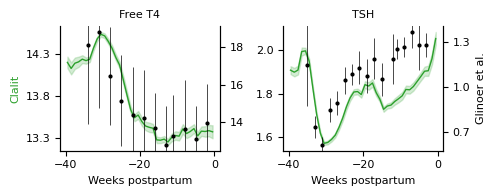

In [41]:
plt.figure(figsize=(5,2))
ax   = plt.subplot(121)
axt  = ax.twinx()
test = 'T4_FREE'
tdf  = get_test_data(test)['value_at_quantile'].loc[-40:0]
ref  = glinoer_t4_df

ax.plot(tdf.index,tdf.value,lw=1,c=def_color[2]); 
ax.fill_between(tdf.index,tdf.value+tdf.error,tdf.value-tdf.error,color=def_color[2],alpha=0.2)
axt.plot(ref.index,ref.value,lw=0); ylm = axt.get_ylim()
axt.errorbar(ref.index,ref.value,ref.error,c='k',lw=0.5,fmt='o',markersize=2); axt.set_ylim(ylm)
ax.spines['top'].set_visible(False)
axt.spines['top'].set_visible(False)
ax.set_xlabel('Weeks postpartum',fontsize=8);
ax.set_ylabel('Clalit',fontsize=8,color=def_color[2]);
# axt.set_ylabel('Glinoer et al.',fontsize=8);
ax.set_yticks([13.3,13.8,14.3])
axt.set_yticks([14,16,18])
ax.set_title(metadata.loc[test]['Nice name'])


ax   = plt.subplot(122)
axt  = ax.twinx()
test = 'TSH_THYROID_STIMULATING_HORMONE'
tdf  = get_test_data(test)['value_at_quantile'].loc[-40:0]
ref  = glinoer_tsh_df

ax.plot(tdf.index,tdf.value,lw=1,c=def_color[2]); 
ax.fill_between(tdf.index,tdf.value+tdf.error,tdf.value-tdf.error,color=def_color[2],alpha=0.2)
axt.plot(ref.index,ref.value,lw=0); ylm = axt.get_ylim()
axt.errorbar(ref.index,ref.value,ref.error,c='k',lw=0.5,fmt='o',markersize=2); axt.set_ylim(ylm)
ax.spines['top'].set_visible(False)
axt.spines['top'].set_visible(False)
ax.set_xlabel('Weeks postpartum',fontsize=8);
axt.set_ylabel('Glinoer et al.',fontsize=8);
ax.set_title(metadata.loc[test]['Nice name'])
ax.set_yticks([1.6,1.8,2])
axt.set_yticks([0.7,1,1.3])

plt.tight_layout(); 
plt.savefig('compare_clalit_to_glinoer_curves.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

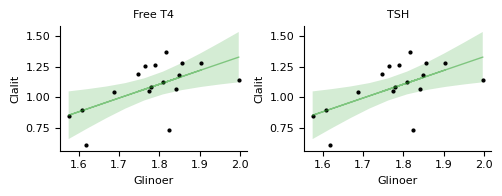

In [42]:
plt.figure(figsize=(5,2))
ax   = plt.subplot(121)
test = 'T4_FREE'
idx  = ref.index
line_reg(tdf.iloc[[np.argmin(np.abs(tdf.index - i)) for i in idx]]['value'].values,ref['value'],ax,c=def_color[2])
ax.set_xlabel('Glinoer',fontsize=8);
ax.set_ylabel('Clalit',fontsize=8);
remove_top_right_frame([ax])
ax.set_title(metadata.loc[test]['Nice name'])

ax   = plt.subplot(122)
test = 'TSH_THYROID_STIMULATING_HORMONE'
idx  = ref.index
line_reg(tdf.iloc[[np.argmin(np.abs(tdf.index - i)) for i in idx]]['value'].values,ref['value'],ax,c=def_color[2])
remove_top_right_frame([ax])
ax.set_xlabel('Glinoer',fontsize=8);
ax.set_ylabel('Clalit',fontsize=8);
ax.set_title(metadata.loc[test]['Nice name'])

plt.tight_layout(); 
plt.savefig('compare_clalit_to_glinoer_regression.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()